## Header

In [1]:
import os
from time import time, process_time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from misc.utility import *
from LSTM.LSTM import *

## Data Preprocessing

In [2]:
"""
Running DataCleaner module to generate preprocessed data
under LSTM/preprocessing/{TODAY} by default
"""
import DataCleaner

# Demographic FIPS= 3114 , # Motality FIPS= 2939 , # Mobility FIPS= 3172
First date to be trained: 2020-03-01 00:00:00 , Final date to be trained: 2020-05-23 00:00:00
..........Preprocessing finished.


When successfully executed, the preprocessed data are generated in LSTM/preprocessing/{TODAY}. 

## Model run

Categorical data of shape (3114, 51) is loaded.
Timeseries data of shape (3114, 84, 8) is loaded.
# of features = 59
target_idx: 1
Training multi-output model.
Train for 2500 steps
Epoch 1/20
2500/2500 - 20s - loss: 0.0215
Epoch 2/20
2500/2500 - 20s - loss: 0.0161
Epoch 3/20
2500/2500 - 19s - loss: 0.0121
Epoch 4/20
2500/2500 - 20s - loss: 0.0168
Epoch 5/20
2500/2500 - 20s - loss: 0.0154
Epoch 6/20
2500/2500 - 20s - loss: 0.0170
Epoch 7/20
2500/2500 - 20s - loss: 0.0143
Epoch 8/20
2500/2500 - 20s - loss: 0.0112
Epoch 9/20
2500/2500 - 19s - loss: 0.0146
Epoch 10/20
2500/2500 - 20s - loss: 0.0138
Epoch 11/20
2500/2500 - 20s - loss: 0.0155
Epoch 12/20
2500/2500 - 19s - loss: 0.0136
Epoch 13/20
2500/2500 - 20s - loss: 0.0106
Epoch 14/20
2500/2500 - 20s - loss: 0.0137
Epoch 15/20
2500/2500 - 20s - loss: 0.0133
Epoch 16/20
2500/2500 - 19s - loss: 0.0147
Epoch 17/20
2500/2500 - 19s - loss: 0.0135
Epoch 18/20
2500/2500 - 19s - loss: 0.0100
Epoch 19/20
2500/2500 - 20s - loss: 0.0132
Epoch 20/20

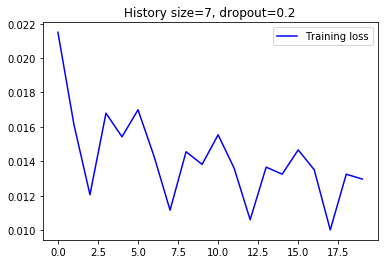

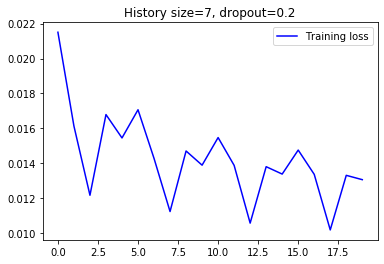

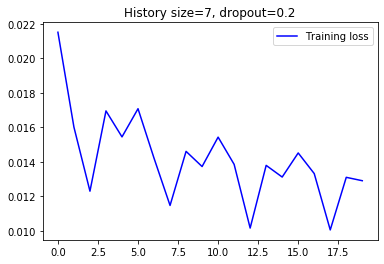

In [3]:
homedir = get_homedir()

TODAY = '0526' # Date of today. Only used in defining PATH_PREP variable(= which folder to search for data)

PATH_PREP = f"{homedir}/LSTM/preprocessing/{TODAY}" # Which folder to search for the preprocessed data.
PATH = f"{homedir}/LSTM/prediction/{TODAY}"         # All outputs will be saved in this folder.

with open(PATH_PREP+f'/date_ed.txt', 'r') as f:
    date_ed = pd.Timestamp(f.read()) # Last date in the preprocessed data. 
                                     # Same as the final date to be trained in the previous cell.
timedelta = 0 # How many dates from date_ed not to be included in training.
              # Only necessary for using custom training timeline.
split_ratio = None              # Training-validation splitting ratio
QUANTILE = list(quantileList)   
history_size = 7                # Size of history window
target_size = 14                # Size of target window
step_size = 1                   
NUM_CELLS = 128                 # Number of cells in LSTM layer
lr = 0.001                      # Learning rate
dp = 0.2                        # Dropout rate
EPOCHS = 20                     # Number of epochs for training
#######################################################################################
"""
Load necessary data from PATH_PREP.
"""
with open(PATH_PREP+f'/FIPS.txt', 'r') as f:
    FIPS_total = eval(f.read())

data_ctg = np.load(PATH_PREP+f'/data_ctg.npy', allow_pickle=True)
print(f'Categorical data of shape {data_ctg.shape} is loaded.')
data_ts = np.load(PATH_PREP+f'/data_ts.npy', allow_pickle=True)
print(f'Timeseries data of shape {data_ts.shape} is loaded.')
if timedelta>0:
    data_ts = data_ts[:, :-timedelta, :]

with open(PATH_PREP+f'/columns_ctg.txt', 'r') as f:
    columns_ctg = eval(f.read())
with open(PATH_PREP+f'/columns_ts.txt', 'r') as f:
    columns_ts = eval(f.read())
print(f'# of features = {len(columns_ctg)+len(columns_ts)}')

target_idx = columns_ts.index('deaths')
print('target_idx:', target_idx)

try:
    os.mkdir(PATH)
except OSError as error:
    print(error)

"""
Generate the training data, an instance of tensorflow.Dataset class.
"""
X_train, y_train, C_train = train_full(data_ts, data_ctg, target_idx, history_size, target_size, step_size=step_size)

scaler_ts, scaler_ctg = get_StandardScaler(X_train, C_train)

X_train, y_train = normalizer(scaler_ts, X_train, y_train, target_idx)
C_train = normalizer(scaler_ctg, C_train)

train_data = load_Dataset(X_train, C_train, y_train)

"""
Train the model and forecast.
"""
for i in range(3):      # For the sake of stability, train 3 models and take average.
    # Build and fit conditional LSTM network
    model, history = LSTM_fit_mult(train_data, lr=lr, NUM_CELLS=NUM_CELLS, EPOCHS=EPOCHS, dp=dp, monitor=True, earlystop=False, verbose=2)
    # Save learning curve and model weights
    FILEPATH = f"/LSTM_mult_hist_size_{history_size}"
    plot_train_history(history, title=f'History size={history_size}, dropout={dp}', path=PATH+FILEPATH+f'_history_{i}.png')
    model.save_weights(PATH+FILEPATH+f'_weights', save_format="tf")
    # Forecast the future and save
    df_future = predict_future_mult(model, data_ts, data_ctg, scaler_ts, scaler_ctg, history_size, target_idx, FIPS=FIPS_total, date_ed=date_ed-pd.Timedelta(days=timedelta))
    df_future.to_csv(PATH+FILEPATH+f'_{TODAY}_{i}.csv', index=False)

"""
Combine the forecasts into the submission format.
"""
forecasted = [pd.read_csv(PATH+FILEPATH+f'_{TODAY}_{i}.csv', parse_dates=[0]) for i in range(3)]

df_submission = prediction_to_submission(forecasted)
df_submission.to_csv(f'{homedir}/submissions/LSTM_final.csv', index=False)

### Running time: apprx. ~25 m
Requirement: tensorflow >= 2.0 (Not tested on tf 2.2)

System: tested on Windows and Ubuntu